# BUFN402: Homework 2
## By James Zhang, 118843940

In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### 1a

CAPM assumes that all investors face the same investment opportunities, 
and they borrow at the same equilibrium risk-free rate. Recall that the risk-free savings rate $r_s$ is the rate of return of an investment with no risk of financial loss and the risk-free borrowing rate $r_b$ is the rate at which someone can borrow funds. Assuming this is not true, and that the risk-free saving rate $r_s$ and risk-free
borrowing rate are different such that $r_s < r_b$, then the mean variance frontier will be two line segments, which pivots at the tangency portfolio. Below the purple dot, the investor buys the risk free savings rate at $r_s$ and after the point sells to remain leveraged at the $r_b$ rate.

![alt text](1a.png "1a")

### 1b

This table does not satisfy the CAPM's results. An 
important result of the CAPM is that since every trader 
is a mean-variance optimizer. Even if traders have different 
risk-tolerances, they will hold the same risky tangent portfolio 
$T$ with maximum Sharpe Ratio, just with different weight to the 
tangent portfolio's weights. The different risk aversion (tolerances) 
simply adjust the weight of the risk-free asset and the weight of the tangent portfolio. 
However, the ratio of bonds to stocks for all of the investors should be the 
same. Since they aren't, not all investors are holding the tangent portfolio, 
so this defies the CAPM. 

### 2a

In [4]:
rf = 0.01
# Convert percentages to decimals by dividing by 100
df = pd.read_csv("ind30_m_vw_rets.csv").drop(columns=["Unnamed: 0"]) / 100
# Remove weird spaces from column names
df = df.rename(columns={col: col.replace(' ', '') for col in df.columns})
# Part a) Multiply df by 12 to annualize returns and covariances
df *= 12
df.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
0,0.0672,-0.6228,0.1548,0.3516,1.3164,-0.0576,0.9696,0.2124,0.9768,0.0468,...,0.0996,1.1064,0.2472,0.9240,0.2316,-2.8548,0.0084,0.2244,0.0444,0.6240
1,0.3108,3.2436,0.7800,0.0660,1.2012,-0.4296,-0.3012,0.5100,0.6600,0.9768,...,0.2604,0.2424,0.5268,-0.2856,0.5856,0.6468,-0.0900,-0.0156,0.5352,0.8112
2,0.1392,0.4824,0.1512,0.7896,-0.1188,0.0876,-0.0612,0.0828,0.6396,0.2772,...,0.2892,0.2700,0.0228,-0.6648,0.0060,-0.9444,0.0300,-0.0672,-0.1476,-0.4632
3,-0.3672,-0.3972,0.1272,-0.5712,1.1364,-0.5616,0.0144,-0.0684,-0.5712,0.1200,...,-0.0132,-0.2400,-0.1308,-0.6096,-0.3168,-1.8456,-0.2640,-0.4932,-0.6192,-1.0188
4,0.7620,0.8748,0.5460,0.1992,-0.6960,-0.0648,0.2244,0.6504,0.6240,0.3732,...,0.1956,0.4524,0.4368,0.4608,0.1920,0.5604,0.7824,0.5196,0.2688,0.4800


### 2b

Consider the case of $N$ risky assets. Let us define $w: N \times 1$ is a column vector of portfolio weights, $\mu: N \times 1$ is a column vector of risky asset expected returns, $\sigma: N \times 1$ is a column vector of risky asset standard deviations, and $\Sigma: N \times N$ is the covariance matrix.
$$E(R_p) = w^T \mu$$
$$Var(R_p) = w^T \Sigma w$$

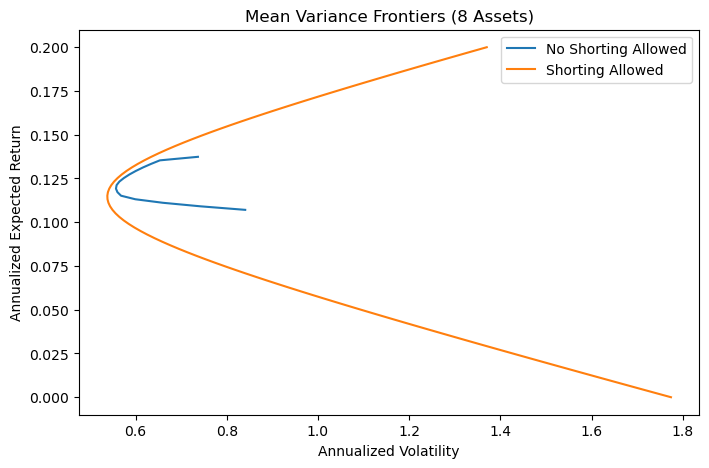

In [5]:
# Cutting df down to contain our risky assets
df_8 = df[["Smoke", "Fin", "Games", "Coal", "Food", "Autos", "Books", "ElcEq"]]
# Algorithm: fix desired expected return and use scipy.optimize to minimize portfolio variance
expected_returns = np.linspace(0, 0.2, 100)
no_shorting_expected_returns = []
no_shorting_volatilities, yes_shorting_volatilities = [], []
N = 8
mu, Sigma = np.array(df_8.mean()), np.array(df_8.cov())

def objective_func(weights, cov_matrix):
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    return portfolio_volatility


for i, target_return in enumerate(expected_returns):

    # Define constraints
    sum_to_one_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    target_return_constraint = {'type': 'eq', 'fun': lambda weights: np.dot(weights, mu) - target_return}
    cons = [target_return_constraint, sum_to_one_constraint]

    # Not allowing shorting case
    w0 = np.ones(N) / N
    res = minimize(objective_func, x0=w0, args=(Sigma,), constraints=cons, bounds=[(0, None)] * N, tol=1e-6)
    if res.success:
        no_shorting_expected_returns.append(target_return)
        no_shorting_volatilities.append(res.fun)

    # Allowing shorting case
    w0 = np.random.random(N)
    w0 /= np.sum(w0)
    yes_shorting_min_vol = minimize(objective_func, x0=w0, args=(Sigma,), constraints=cons, tol=1e-6).fun
    yes_shorting_volatilities.append(yes_shorting_min_vol)

no_shorting_expected_returns = np.array(no_shorting_expected_returns)
no_shorting_volatilities = np.array(no_shorting_volatilities)
yes_shorting_volatilities = np.array(yes_shorting_volatilities)

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(no_shorting_volatilities, no_shorting_expected_returns, label="No Shorting Allowed")
plt.plot(yes_shorting_volatilities, expected_returns, label="Shorting Allowed")
ax.set_title("Mean Variance Frontiers (8 Assets)")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Expected Return")
ax.legend()
fig.show()

### 2c

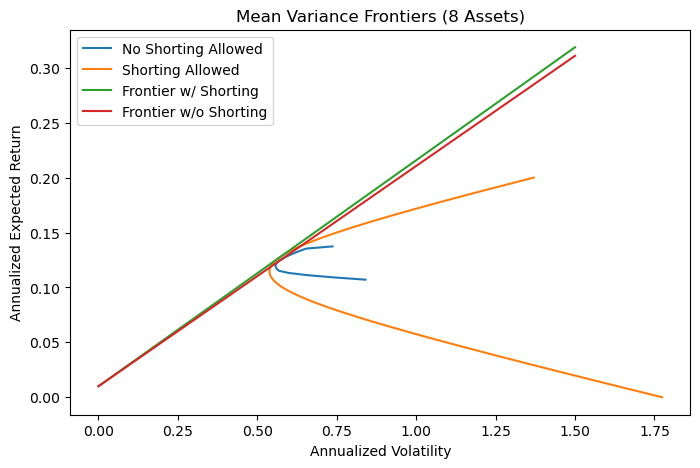

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(no_shorting_volatilities, no_shorting_expected_returns, label="No Shorting Allowed")
plt.plot(yes_shorting_volatilities, expected_returns, label="Shorting Allowed")
x = np.linspace(0, 1.5, 1000)
plt.plot(x, x * max((expected_returns - rf) / yes_shorting_volatilities) + rf, label="Frontier w/ Shorting")
plt.plot(x, x * max((no_shorting_expected_returns - rf) / no_shorting_volatilities) + rf, label="Frontier w/o Shorting")
ax.set_title("Mean Variance Frontiers (8 Assets)")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Expected Return")
ax.legend()
fig.show()

### 2d

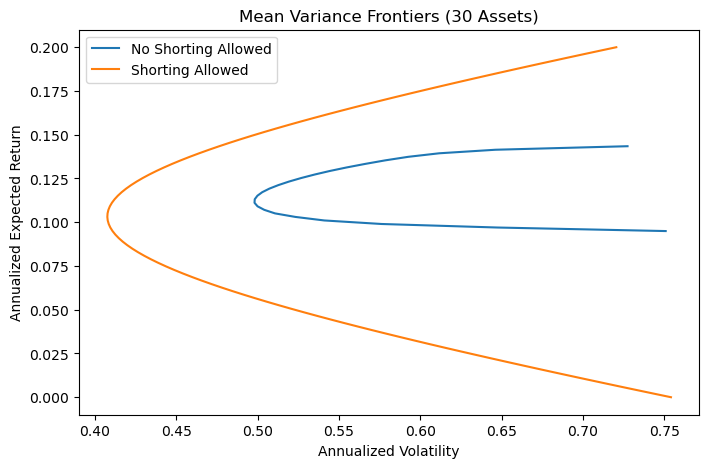

In [7]:
# Cutting df down to contain our risky assets
# Algorithm: fix desired expected return and use scipy.optimize to minimize portfolio variance
expected_returns = np.linspace(0, 0.2, 100)
no_shorting_expected_returns = []
no_shorting_volatilities, yes_shorting_volatilities = [], []

# Store weights here; use this to find the tangent portfolio and minimum variance portfolio later on
yes_shorting_weights = []
N = len(df.columns)
mu, Sigma = np.array(df.mean()), np.array(df.cov())

def objective_func(weights, cov_matrix):
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    return portfolio_volatility


for i, target_return in enumerate(expected_returns):

    # Define constraints
    sum_to_one_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    target_return_constraint = {'type': 'eq', 'fun': lambda weights: np.dot(weights, mu) - target_return}
    cons = [target_return_constraint, sum_to_one_constraint]

    # Not allowing shorting case
    w0 = np.ones(N) / N
    res = minimize(objective_func, x0=w0, args=(Sigma,), constraints=cons, bounds=[(0, None)] * N, tol=1e-6)
    if res.success:
        no_shorting_expected_returns.append(target_return)
        no_shorting_volatilities.append(res.fun)

    # Allowing shorting case
    w0 = np.random.random(N)
    w0 /= np.sum(w0)
    res = minimize(objective_func, x0=w0, args=(Sigma,), constraints=cons, tol=1e-6)
    yes_shorting_min_vol = res.fun
    yes_shorting_weights.append(res.x)
    yes_shorting_volatilities.append(yes_shorting_min_vol)

no_shorting_expected_returns = np.array(no_shorting_expected_returns)
no_shorting_volatilities = np.array(no_shorting_volatilities)
yes_shorting_volatilities = np.array(yes_shorting_volatilities)

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(no_shorting_volatilities, no_shorting_expected_returns, label="No Shorting Allowed")
plt.plot(yes_shorting_volatilities, expected_returns, label="Shorting Allowed")
ax.set_title("Mean Variance Frontiers (30 Assets)")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Expected Return")
ax.legend()
fig.show()

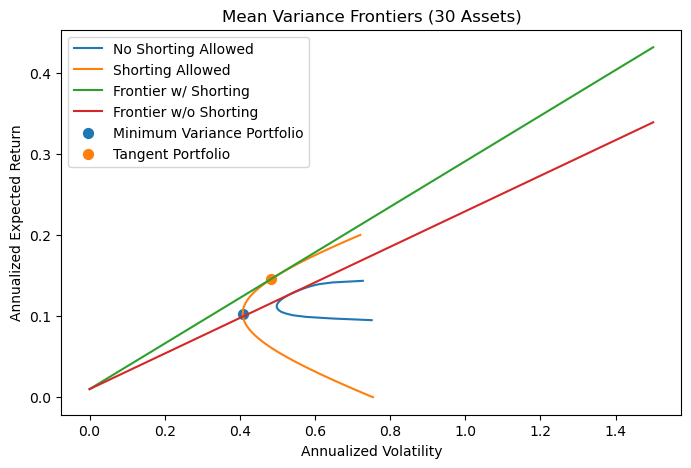

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(no_shorting_volatilities, no_shorting_expected_returns, label="No Shorting Allowed")
plt.plot(yes_shorting_volatilities, expected_returns, label="Shorting Allowed")
x = np.linspace(0, 1.5, 1000)
plt.plot(x, x * max((expected_returns - rf) / yes_shorting_volatilities) + rf, label="Frontier w/ Shorting")
plt.plot(x, x * max((no_shorting_expected_returns - rf) / no_shorting_volatilities) + rf, label="Frontier w/o Shorting")
plt.scatter(np.min(yes_shorting_volatilities), expected_returns[np.argmin(yes_shorting_volatilities)], label="Minimum Variance Portfolio", s=50)
plt.scatter(yes_shorting_volatilities[np.argmax(expected_returns / yes_shorting_volatilities)], expected_returns[np.argmax(expected_returns / yes_shorting_volatilities)], label="Tangent Portfolio", s=50)
ax.set_title("Mean Variance Frontiers (30 Assets)")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Expected Return")
ax.legend()
fig.show()

In [9]:
yes_shorting_weights[np.argmin(yes_shorting_volatilities)], np.min(yes_shorting_volatilities) ** 2

(array([ 2.99401952e-01,  1.02592554e-03,  7.34056741e-02, -1.26702868e-01,
        -6.21232711e-02,  8.00532058e-02,  1.78711719e-01,  9.61207531e-02,
        -2.72580687e-02,  9.34979293e-03, -9.56966506e-02, -8.27302565e-02,
        -9.59630290e-02, -1.52267431e-01,  5.69890602e-03, -1.19894829e-02,
         1.23233405e-01, -2.96649163e-02,  1.69191864e-01,  1.87181696e-01,
         4.44105738e-01,  5.07201101e-03,  1.04019875e-01,  1.05996190e-01,
         9.70729754e-02, -1.63794262e-03, -1.29125215e-02,  1.20066192e-02,
        -2.92291328e-01, -4.10534842e-04]),
 0.16615018308721213)

In [10]:
yes_shorting_weights[np.argmax(expected_returns / yes_shorting_volatilities)], np.max(expected_returns / yes_shorting_volatilities)

(array([ 0.13318001,  0.16263039,  0.25237924, -0.05505554, -0.115541  ,
        -0.0774272 ,  0.15297645,  0.16692424,  0.07941963,  0.03595398,
        -0.29445224, -0.23379319, -0.06283194,  0.01471314,  0.07632006,
         0.13625607,  0.09526605,  0.00969675,  0.22388603,  0.08340817,
         0.26933311,  0.08304199,  0.18683482,  0.12542306, -0.020465  ,
        -0.15901172,  0.0883895 ,  0.06899205, -0.19116015, -0.23528677]),
 0.3011839993167813)

### 2e

I would argue that yes, the tangent portfolio here is statistically noisy. While our method of finding the tangent, optimal portfolio is extremely statistical, I believe that the weights of tangent portfolio themselves are noisy and not robust at all. Consider the covariance matrix of the 30 assets below.

In [11]:
Sigma, list(filter(lambda x: x < 0, Sigma.flatten()))

(array([[0.32265026, 0.34313587, 0.26366159, 0.4278295 , 0.35605357,
         0.31548488, 0.26707944, 0.29397936, 0.31526355, 0.3546473 ,
         0.36144576, 0.36438435, 0.35497052, 0.3855143 , 0.3583689 ,
         0.36216414, 0.25113264, 0.3653125 , 0.2491698 , 0.26504702,
         0.20418032, 0.23527988, 0.28987007, 0.30295767, 0.34032713,
         0.34380897, 0.32573651, 0.32154586, 0.37026999, 0.33129859],
        [0.34313587, 0.74354876, 0.27395224, 0.59421737, 0.44223381,
         0.39516312, 0.32215072, 0.36776237, 0.39963857, 0.48517259,
         0.48758556, 0.47196961, 0.46693299, 0.48360046, 0.45894895,
         0.48210443, 0.33999325, 0.48084739, 0.31529819, 0.32748924,
         0.2411125 , 0.29527914, 0.37197444, 0.37424455, 0.44552441,
         0.50195803, 0.40041496, 0.42377337, 0.46981374, 0.43720738],
        [0.26366159, 0.27395224, 0.48580438, 0.36272468, 0.28712183,
         0.26610699, 0.2212222 , 0.26022268, 0.26256743, 0.28639604,
         0.30678303, 0.31408893,

There is not a single negative number within our entire covariance matrix. From a economic point of view, this means that all of our assets are postiively correlated with each other. Recall that the variance of our portfolio is given as 
$$\text{Var}(R_p) = \sum w_i^2 \sigma_i^2 + 2\sum_{i < j}w_i w_j \text{Cov}(R_i, R_j)$$
Thus, from an economic point of view, with all positive covariances, we can never decrease the variance of our portfolio, or hedge our positions. We can only choose assets such that the variance increases the least. I argue that this situation is statstically noisy essentially we're heavily weighting assets whose industries have no relation to each other. This is quite random and intuitively kind of noisy. Alternatively, if there was one other asset in our universe with negative covariances with some of the other assets, our tangent portfolio weights would look extremely different our portfolio would be far more truly "diversifed."

### 3a

In [27]:
df = pd.read_csv("F-F_Research_Data_Factors_monthly.csv") / 100

def date_helper(date):
    date = str(date)
    return pd.to_datetime(f"{date[:4]}-{date[5:]}")

df["Date"] = df["mon"].apply(date_helper)
mkt_rf = df[["Date", "Mkt-RF", "RF"]]
df = df.drop(columns=["mon"])
df = df.set_index("Date")
ff3 = df.copy()

model = LinearRegression()
X = df["Mkt-RF"].to_numpy().reshape(-1, 1)
y = (df["HML"] - df["RF"]).to_numpy().reshape(-1, 1)
model.fit(X, y)
alpha = model.intercept_[0]
beta = model.coef_[0][0]
average_hml_return = (df["HML"]).mean()
print(f"Average HML Return={average_hml_return}, Alpha={alpha}, Beta={beta}")
print(f"""Of the Average HML Return, {(average_hml_return - alpha) * 100 / average_hml_return}% 
      is systematic and {alpha * 100/average_hml_return}% is excess to CAPM""")

Average HML Return=0.0009339639639639641, Alpha=-8.638113103718714e-05, Beta=0.1567957935363723
Of the Average HML Return, 109.24887194475525% 
      is systematic and -9.248871944755253% is excess to CAPM


### 3b

Beta is positive, so the market portfolio and the returns on the HML strategy are directly correlated. Thus, the strategy does better when the market performs better.

### 3c

Recall that $\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}$, which represents sensitivity to the market index. Thus, $\beta \approx 15.37\%$ of the variability in the HML PF returns can be explained by market wide movements.

### 3d

Prior to the publication of this strategy, there should be a clear relationship between betas and average excess returns. Almost all of the average HML return should be systematic, or explained by the variation in the market portfolio. Alpha should be close to 0, as this satisfies the CAPM. After the publication of this strategy, more people will try to use it to make money, which will cause multiple things to happen. By running regressions in both time periods, I predict that the post-1993 average HML return will explained less by the market, and there will be al essclear, possibly inverse relationship between betas and expected excess return. The existence of a positive alpha will confirm that the returns of the portfolios are less explained by the market. 

In [13]:
pre_1993 = df[df.index < pd.to_datetime('1993-01')]
model = LinearRegression()
X = pre_1993["Mkt-RF"].to_numpy().reshape(-1, 1)
y = (pre_1993["HML"] - pre_1993["RF"]).to_numpy().reshape(-1, 1)
model.fit(X, y)
alpha = model.intercept_[0]
beta = model.coef_[0][0]
average_hml_return = pre_1993["HML"].mean()
print(f"Average HML Return={average_hml_return}, Alpha={alpha}, Beta={beta}")
print(f"""Of the Average HML Return, {(average_hml_return - alpha) * 100 / average_hml_return}% 
      is systematic and {alpha * 100/average_hml_return}% is excess to CAPM""")

Average HML Return=0.0043031328320802, Alpha=-0.000141225528949447, Beta=0.2131097010273286
Of the Average HML Return, 103.28192353014528% 
      is systematic and -3.281923530145278% is excess to CAPM


In [14]:
post_1993 = df[df.index >= pd.to_datetime('1993-01')]
X = post_1993["Mkt-RF"].to_numpy().reshape(-1, 1)
y = (post_1993["HML"] - post_1993["RF"]).to_numpy().reshape(-1, 1)
model.fit(X, y)
alpha = model.intercept_[0]
beta = model.coef_[0][0]
average_hml_return = post_1993["HML"].mean()
print(f"Average HML Return={average_hml_return}, Alpha={alpha}, Beta={beta}")
print(f"""Of the Average HML Return, {(average_hml_return - alpha) * 100 / average_hml_return}% 
      is systematic and {alpha * 100/average_hml_return}% is excess to CAPM""")

Average HML Return=0.002069871794871794, Alpha=0.0007541634013428375, Beta=-0.10661637411483195
Of the Average HML Return, 63.56472882951915% 
      is systematic and 36.43527117048086% is excess to CAPM


### 4a

In [15]:
df = pd.read_csv("BM_PF_10_mon_vw_PA2.csv") / 100

def date_helper(date):
    date = str(date)
    return pd.to_datetime(f"{date[:4]}-{date[4:]}")

df["Date"] = df["mon"].apply(date_helper)
df = df.drop(columns=["mon"])
df = df.set_index("Date")

# Running CAPM regressions on the ten B/M portfolios on excess market returns
df_a = df[(df.index >= pd.to_datetime('1963-01')) & (df.index < pd.to_datetime('2016-01'))]
mkt_a = mkt_rf[(mkt_rf["Date"] >= pd.to_datetime('1963-01')) & (mkt_rf["Date"] < pd.to_datetime('2016-01'))]

# Sample Averages
print(f"Sample Averages: \n{df_a.mean()}")

# Run the Linear Regressions on all 10 portfolios
model = LinearRegression()
bm_portfolios = df.columns
alphas_capm, betas_capm = [], []
for bm in bm_portfolios:
    # Define X and Y for regression
    X = mkt_a["Mkt-RF"].to_numpy().reshape(-1, 1)
    y = (df_a[bm].values - mkt_a["RF"].values).reshape(-1, 1)
    model.fit(X, y)
    alphas_capm.append(model.intercept_[0])
    betas_capm.append(model.coef_[0][0])

for bm, alpha, beta in zip(bm_portfolios, alphas_capm, betas_capm):
    print(f"B/M: {bm}, Alpha = {alpha}, Beta = {beta}")

Sample Averages: 
Lo 10    0.008159
2-Dec    0.009498
3-Dec    0.009460
4-Dec    0.009330
5-Dec    0.009449
6-Dec    0.010657
7-Dec    0.010330
8-Dec    0.011144
9-Dec    0.012392
Hi 10    0.013110
dtype: float64
B/M: Lo 10, Alpha = -0.0012233581523273399, Beta = 1.058945874647164
B/M: 2-Dec, Alpha = 0.00036917680440186514, Beta = 1.0093396882205552
B/M: 3-Dec, Alpha = 0.00042502117825842303, Beta = 0.9909654597262043
B/M: 4-Dec, Alpha = 0.0003648539760164049, Beta = 0.9772708103475208
B/M: 5-Dec, Alpha = 0.0009016597076053181, Beta = 0.895285836763551
B/M: 6-Dec, Alpha = 0.0020826333667589396, Beta = 0.9005563640329516
B/M: 7-Dec, Alpha = 0.0016677143615263365, Beta = 0.9178739031218796
B/M: 8-Dec, Alpha = 0.0024258446506329285, Beta = 0.9288241392459646
B/M: 9-Dec, Alpha = 0.0035020370781546515, Beta = 0.9624004247961663
B/M: Hi 10, Alpha = 0.0034697569008832717, Beta = 1.1096081523264008


### 4b

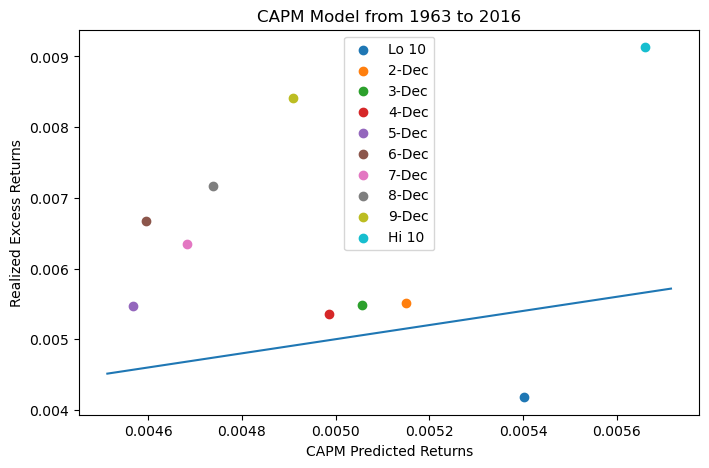

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
for bm, beta in zip(bm_portfolios, betas_capm):
    plt.scatter(x=np.mean(beta * mkt_a['Mkt-RF']), y=(df_a[bm].values - mkt_a["RF"].values).mean(), label=bm)

ax.legend()
plt.xlabel("CAPM Predicted Returns")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
plt.ylabel("Realized Excess Returns")
plt.title("CAPM Model from 1963 to 2016")
fig.show()

### 4c

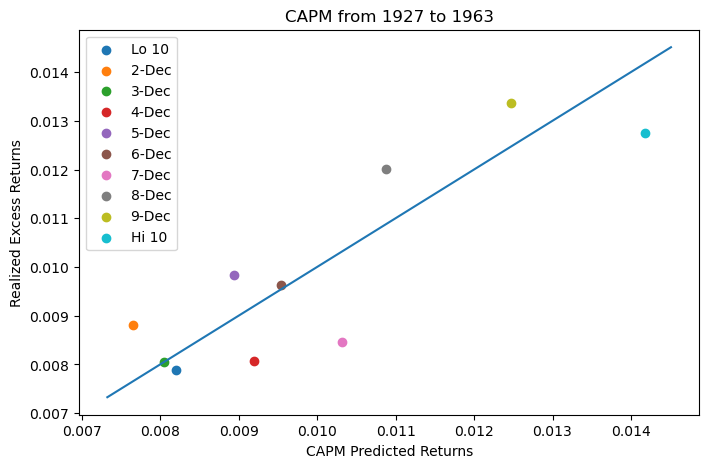

In [23]:
# Get the time periods for part c too
df_c = df[(df.index >= pd.to_datetime('1927-01')) & (df.index < pd.to_datetime('1963-01'))]
mkt_c = mkt_rf[(mkt_rf["Date"] >= pd.to_datetime('1927-01')) & (mkt_rf["Date"] < pd.to_datetime('1963-01'))]

# Run the Linear Regressions on all 10 portfolios
model = LinearRegression()
bm_portfolios = df.columns
alphas_capm_modern, betas_capm_modern = [], []
for bm in bm_portfolios:
    # Define X and Y for regression
    X = mkt_c["Mkt-RF"].to_numpy().reshape(-1, 1)
    y = (df_c[bm].values - mkt_c["RF"].values).reshape(-1, 1)
    model.fit(X, y)
    alphas_capm_modern.append(model.intercept_[0])
    betas_capm_modern.append(model.coef_[0][0])

fig, ax = plt.subplots(figsize=(8, 5))
for bm, beta in zip(bm_portfolios, betas_capm_modern):
    plt.scatter(x=np.mean(beta * mkt_c["Mkt-RF"]), y=(df_c[bm].values - mkt_c["RF"].values).mean(), label=bm)
    
ax.legend()
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
plt.xlabel("CAPM Predicted Returns")
plt.ylabel("Realized Excess Returns")
plt.title("CAPM from 1927 to 1963")
fig.show()

### 4d

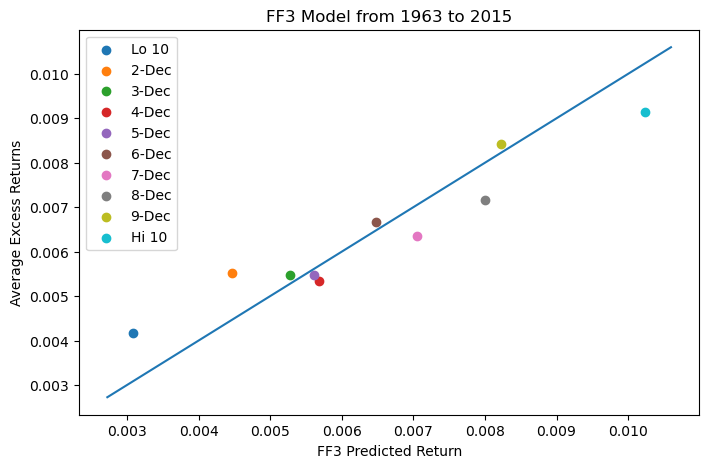

In [26]:
df_d = df[(df.index >= pd.to_datetime('1963-01')) & (df.index < pd.to_datetime('2016-01'))]
ff3_d = ff3[(ff3.index >= pd.to_datetime('1963-01')) & (ff3.index < pd.to_datetime('2016-01'))]

alphas_ff3, betas_ff3 = [], []

model = LinearRegression()
for bm in bm_portfolios:
    X = (ff3_d[["Mkt-RF", "SMB", "HML"]]).to_numpy()
    y = (df_d[bm] - ff3_d["RF"]).to_numpy().reshape(-1, 1)
    model.fit(X, y)
    alphas_ff3.append(model.intercept_[0])
    betas_ff3.append(model.coef_[0])

fig, ax = plt.subplots(figsize=(8, 5))
for bm, (beta_rf, beta_smb, beta_hml), alpha in zip(bm_portfolios, betas_ff3, alphas_ff3):
    ff3_predicted =  beta_rf * ff3_d["Mkt-RF"] + beta_smb * ff3_d["SMB"] + beta_hml * ff3_d["HML"]
    ff3_predicted = np.mean(ff3_predicted)
    plt.scatter(x=ff3_predicted, y=(df_d[bm].values - mkt_a["RF"].values).mean(), label=bm)
ax.legend()

x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
plt.xlabel("FF3 Predicted Return")
plt.ylabel("Average Excess Returns")
plt.title("FF3 Model from 1963 to 2015")
fig.show()

### 4e

Comparing the alphas and factor loadings between CAPM and FF3

In [25]:
for bm, alpha_capm, alpha_ff3, beta_capm, beta_ff3 in zip(bm_portfolios, alphas_capm, alphas_ff3, betas_capm, betas_ff3):
    print(f"B/M: {bm}, CAPM alpha={alpha_capm}, FF3 alpha={alpha_ff3}     |     CAPM beta={beta_capm}, FF3 betas={beta_ff3}")

B/M: Lo 10, CAPM alpha=-0.0012233581523273399, FF3 alpha=0.0010957173814620138     |     CAPM beta=1.058945874647164, FF3 betas=[ 1.00263484 -0.12521275 -0.49123721]
B/M: 2-Dec, CAPM alpha=0.00036917680440186514, FF3 alpha=0.0010543667453606059     |     CAPM beta=1.0093396882205552, FF3 betas=[ 0.99582013 -0.0499139  -0.14215417]
B/M: 3-Dec, CAPM alpha=0.00042502117825842303, FF3 alpha=0.00020131412277852277     |     CAPM beta=0.9909654597262043, FF3 betas=[ 1.00364713 -0.01795906  0.05432921]
B/M: 4-Dec, CAPM alpha=0.0003648539760164049, FF3 alpha=-0.0003368252617736685     |     CAPM beta=0.9772708103475208, FF3 betas=[ 1.00655135 -0.0128392   0.16035685]
B/M: 5-Dec, CAPM alpha=0.0009016597076053181, FF3 alpha=-0.00014879023045527226     |     CAPM beta=0.895285836763551, FF3 betas=[ 0.95064022 -0.06695131  0.25109433]
B/M: 6-Dec, CAPM alpha=0.0020826333667589396, FF3 alpha=0.00020561243080942718     |     CAPM beta=0.9005563640329516, FF3 betas=[ 0.97735671 -0.02802147  0.42749956